Déclaration des bibliothèques

In [218]:
import pandas as pd
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display as lbd
import os
import matplotlib
import statistics
import soundfile as sf
import sys
import seaborn as sns

import sklearn as sk
import scipy as sp
import platform


print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

def getFilenameInfo(file):
    return file.split('_')

def GetAudioStartEnd(file,start,end,samplerate):
     file, sr = lb.load(file)
     return file[int(start*samplerate):int(end*samplerate)]


Python Platform: macOS-14.0-arm64-arm-64bit
Tensor Flow Version: 2.8.0

Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
Pandas 2.1.1
Scikit-Learn 1.3.1
SciPy 1.11.3
GPU is available


Preprocessing des fichiers audio

   start    end  crackles  weezels                filename  pid disease
0  0.036  0.579         0        0  101_1b1_Al_sc_Meditron  101    URTI
1  0.579  2.450         0        0  101_1b1_Al_sc_Meditron  101    URTI
2  2.450  3.893         0        0  101_1b1_Al_sc_Meditron  101    URTI
3  3.893  5.793         0        0  101_1b1_Al_sc_Meditron  101    URTI
4  5.793  7.521         0        0  101_1b1_Al_sc_Meditron  101    URTI
mean = 2.700509085242099
median = 2.536999999999999


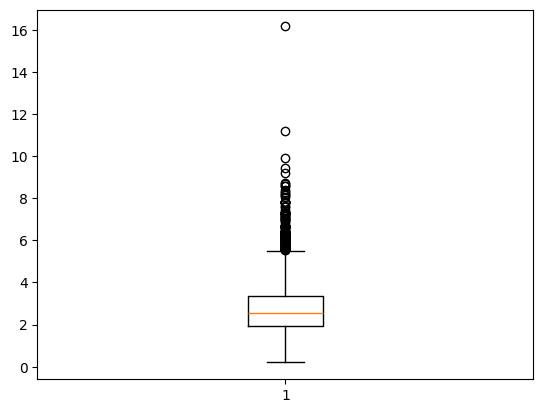

In [219]:
import pandas as pd
import os



patient_data=pd.read_csv('Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
# print(patient_data.head())

df=pd.read_csv('Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Al_mc_AKGC417L.txt',sep='\t')
# print(df.head())

path='Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files.sort()


files_data=[]
for file in files :
    data=pd.read_csv(path+file+'.txt',sep='\t',names=['start','end','crackles','weezels'])
    data['filename']=file
    data['pid']=file[:3]
    files_data.append(data)
list_files=pd.concat(files_data)
list_files.reset_index()
# print(list_files.head())

list_files['pid']=list_files['pid'].astype('Int64')
resume=pd.merge(list_files,patient_data,on='pid')

print(resume.head())

matplotlib.pyplot.boxplot((resume.end-resume.start))
print('mean = '+ str(statistics.mean(resume.end-resume.start)))
print('median = '+ str(statistics.median(resume.end-resume.start)))



Zero padding et longueur équivalente de 6 sec pour tout les fichiers

In [220]:
# maxLenght = 6
# i=0
# c=0
# for index,row in resume.iterrows():

#     start = row.start
#     end = row.end

#     if end-start>maxLenght : 
#         end = start + maxLenght

#     newsoundfile = GetAudioStartEnd("Respiratory_Sound_Database/audio_and_txt_files/"+row.filename+".wav",start,end,samplerate=22050)

#     if index>0 :
#         if resume.iloc[index-1]['filename']==row.filename:
#             i+=1
#         else :
#             i=0


#     pathtosave = "audio_preprocessing/"+row.filename+"_"+str(i)+".wav"

#     padded_data = lb.util.pad_center(data=newsoundfile, size=maxLenght*22050)

#     sf.write(file=pathtosave,data=padded_data,samplerate=22050)
#     c+=1

# print("total enregisrté = "+str(c))

Train / Validation Split

In [221]:
from sklearn.model_selection import train_test_split

path = './audio_preprocessing'
files=[s.split('.')[0] for s in os.listdir(path)]
files.sort()


files_processed=[]
for file in files :
    pid = file.split('_')[0]
    data = pd.DataFrame(np.array([[pid, file]]), columns=['pid', 'file'])
    files_processed.append(data)
files_processed=pd.concat(files_processed)

files_processed['pid']=files_processed['pid'].astype('Int64')
files_processed=pd.merge(files_processed,patient_data,on='pid')

print(files_processed)


x_train,x_valid,y_train,y_valid=train_test_split(files_processed.file,files_processed.disease,stratify=files_processed.disease,train_size=0.7,random_state=42)

      pid                       file    disease
0     101   101_1b1_Al_sc_Meditron_0       URTI
1     101   101_1b1_Al_sc_Meditron_1       URTI
2     101  101_1b1_Al_sc_Meditron_10       URTI
3     101  101_1b1_Al_sc_Meditron_11       URTI
4     101   101_1b1_Al_sc_Meditron_2       URTI
...   ...                        ...        ...
6893  226   226_1b1_Pl_sc_LittC2SE_5  Pneumonia
6894  226   226_1b1_Pl_sc_LittC2SE_6  Pneumonia
6895  226   226_1b1_Pl_sc_LittC2SE_7  Pneumonia
6896  226   226_1b1_Pl_sc_LittC2SE_8  Pneumonia
6897  226   226_1b1_Pl_sc_LittC2SE_9  Pneumonia

[6898 rows x 3 columns]


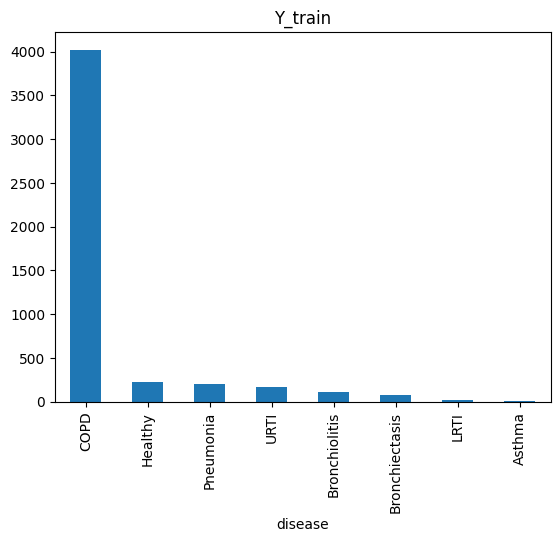

In [222]:

# data = pd.concat([x_train,y_train],axis=1)

# supress = 3500
# i=0
# for index,row in data.iterrows():
    
#     if row.disease=="COPD" and i<supress: 
#         data.drop(index, axis=0,inplace=True)
#         i+=1

# x_train =data.drop(labels="disease", axis=1)
# y_train = data.drop(labels="file", axis=1)

ax = y_train.value_counts().plot.bar()
ax.set_title("Y_train")
plt.show()


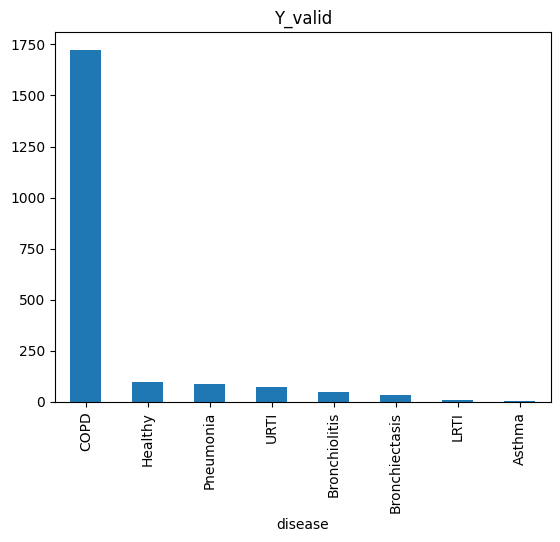

In [223]:
ay = y_valid.value_counts().plot.bar()
ay.set_title("Y_valid")
plt.show()

In [224]:
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.utils import shuffle

# ros = RandomOverSampler(random_state=0)
# x_t = np.array(x_train)
# x_t = x_t.reshape(-1,1)
# y_t = np.array(y_train)
# X_resampled_train, Y_resampled_train = ros.fit_resample(x_t,y_t)
# print(X_resampled_train)

# ay = pd.DataFrame(Y_resampled_train).value_counts().plot.bar()
# ay.set_title("Y_resampled")
# plt.show()
# print(X_resampled_train.shape)
# X_resampled_train = X_resampled_train[:,0]
# print(X_resampled_train.shape)
# np.squeeze(Y_resampled_train)
# print(Y_resampled_train.shape)

# X_resampled_train, Y_resampled_train = shuffle(X_resampled_train,Y_resampled_train)

Model

Model: "model_concat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                     

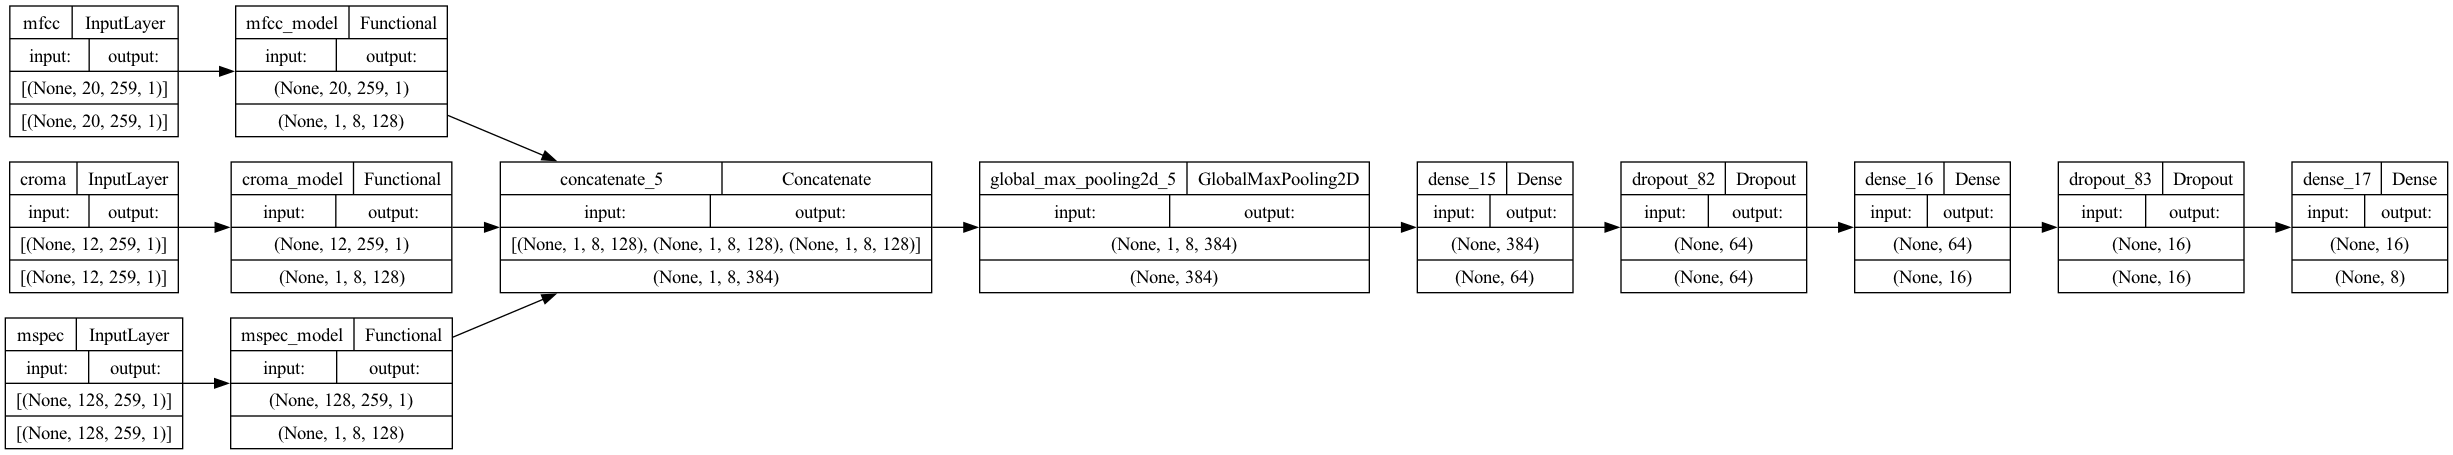

In [279]:
from keras.models import Model
from keras.layers import Input, BatchNormalization, Dropout, Flatten, Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, GlobalMaxPooling2D
from keras.layers import concatenate

mfcc = Input((20, 259, 1))

c00 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (mfcc) 
c00 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c00)
c00 = BatchNormalization()(c00)
p00 = MaxPooling2D((2, 2)) (c00) 
p00 = Dropout(0.25)(p00) 
                    
c0 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p00)
c0 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c0)
c0= BatchNormalization()(c0)
p0 = MaxPooling2D((2, 2)) (c0)
p0 = Dropout(0.25)(p0)

c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p0)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.25)(p1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.25)(p2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p2)
c3 = BatchNormalization()(c3)
mfcc_output = MaxPooling2D(pool_size=(1, 2)) (c3)


mfcc_model = Model(inputs=[mfcc], outputs=[mfcc_output],name="mfcc_model")


croma = Input((12, 259, 1))

c00 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (croma) 
c00 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c00)
c00 = BatchNormalization()(c00)
p00 = MaxPooling2D((2, 2)) (c00) 
p00 = Dropout(0.25)(p00) 
                    
c0 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p00)
c0 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c0)
c0= BatchNormalization()(c0)
p0 = MaxPooling2D((2, 2)) (c0)
p0 = Dropout(0.25)(p0)

c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p0)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.25)(p1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((1, 2)) (c2)
p2 = Dropout(0.25)(p2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p2)
c3 = BatchNormalization()(c3)
croma_output = MaxPooling2D(pool_size=(1, 2)) (c3)

croma_model = Model(inputs=[croma], outputs=[croma_output],name="croma_model") 


mspec = Input((128, 259, 1))

c00 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (mspec) 
c00 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c00)
c00 = BatchNormalization()(c00)
p00 = MaxPooling2D((4, 2)) (c00) 
p00 = Dropout(0.25)(p00) 
                    
c0 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p00)
c0 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c0)
c0= BatchNormalization()(c0)
p0 = MaxPooling2D((2, 2)) (c0)
p0 = Dropout(0.25)(p0)

c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p0)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.25)(p1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((4, 2)) (c2)
p2 = Dropout(0.25)(p2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p2)
c3 = BatchNormalization()(c3)
mspec_output = MaxPooling2D(pool_size=(2, 2)) (c3)


mspec_model = Model(inputs=[mspec], outputs=[mspec_output],name="mspec_model") 

input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mspec=mspec_model(input_mSpec)


  
concat=keras.layers.concatenate([mfcc,croma,mspec])
c1 = GlobalMaxPooling2D()(concat)
c3 = Dense(64, activation="sigmoid")(c1)
c3 = Dropout(0.25)(c3)
c4 = Dense(16, activation="sigmoid")(c3)
c4 = Dropout(0.25)(c4)
concat_output = Dense(8, activation="sigmoid")(c4)

cnn = Model(inputs=[input_mfcc,input_croma,input_mSpec], outputs=[concat_output],name="model_concat")

cnn.summary()

keras.utils.plot_model(cnn, "net.png", show_shapes=True,rankdir="LR")


In [226]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder


le=LabelEncoder()
y_trai=le.fit_transform(y_train)
y_vali=le.fit_transform(y_valid)




In [216]:
print(y_trai)

[4 3 3 ... 3 3 3]


In [227]:
path = 'audio_preprocessing/'

mfcc_valid,croma_valid,mspec_valid=[],[],[]

for file in x_valid : 
    
    file = file+'.wav'
    sound,frequency=lb.load(path+file)
    mfcc_valid.append(lb.feature.mfcc(y=sound,sr=frequency))
    croma_valid.append(lb.feature.chroma_stft(y=sound,sr=frequency))
    mspec_valid.append(lb.power_to_db(lb.feature.melspectrogram(y=sound,sr=frequency),ref=np.max))


mfcc_valid=np.array(mfcc_valid)
croma_valid=np.array(croma_valid)
mspec_valid=np.array(mspec_valid)

print(mfcc_valid.shape)
print(croma_valid.shape)
print(mspec_valid.shape)

/Users/smain/miniforge3/envs/env_tf/lib/python3.9/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


(2070, 20, 259)
(2070, 12, 259)
(2070, 128, 259)


In [228]:

mfcc_train,croma_train,mspec_train=[],[],[]

for file in x_train :
    
    file = file+'.wav'
    sound,frequency=lb.load(path+file)
    mfcc_train.append(lb.feature.mfcc(y=sound,sr=frequency))
    croma_train.append(lb.feature.chroma_stft(y=sound,sr=frequency))
    mspec_train.append(lb.power_to_db(lb.feature.melspectrogram(y=sound,sr=frequency),ref=np.max))
    

mfcc_train=np.array(mfcc_train)
croma_train=np.array(croma_train)
mspec_train=np.array(mspec_train)




In [ ]:
# cnn.load_weights('cnn_respiratory.hdf5') 


In [229]:
filepath_loss = "cnn_respiratory.hdf5" 

checkpoint_acc = ModelCheckpoint(filepath_loss, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

cnn.compile(optimizer=Adam(learning_rate= 0.001), loss='sparse_categorical_crossentropy', metrics=('accuracy'))



history = cnn.fit({"mfcc":mfcc_train,"croma":croma_train,"mspec":mspec_train},y_trai, epochs=100,
                    validation_data=({"mfcc":mfcc_valid,"croma":croma_valid,"mspec":mspec_valid},y_vali),
                    callbacks=checkpoint_acc,batch_size=8) #On donne au model, le nombre d'epoch construit des données d'entrainement de validation et les calbacks pour sauvegarder les poids aux checkpoints crées 


cnn.save('model_cnn_respiratory.keras')

Epoch 1/100


2023-10-04 13:37:30.283464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


604/604 [==============================] - ETA: 0s - loss: 0.8507 - accuracy: 0.8119

2023-10-04 13:38:35.469666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.83285, saving model to cnn_respiratory.hdf5
604/604 [==============================] - 82s 102ms/step - loss: 0.8507 - accuracy: 0.8119 - val_loss: 0.6496 - val_accuracy: 0.8329
Epoch 2/100
604/604 [==============================] - ETA: 0s - loss: 0.5946 - accuracy: 0.8333
Epoch 2: val_accuracy did not improve from 0.83285
604/604 [==============================] - 40s 67ms/step - loss: 0.5946 - accuracy: 0.8333 - val_loss: 0.5688 - val_accuracy: 0.8319
Epoch 3/100
604/604 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.8353
Epoch 3: val_accuracy did not improve from 0.83285
604/604 [==============================] - 39s 65ms/step - loss: 0.5154 - accuracy: 0.8353 - val_loss: 0.5048 - val_accuracy: 0.8304
Epoch 4/100
604/604 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.8384
Epoch 4: val_accuracy did not improve from 0.83285
604/604 [==============================] - 39s 65ms/step - loss: 

Performance

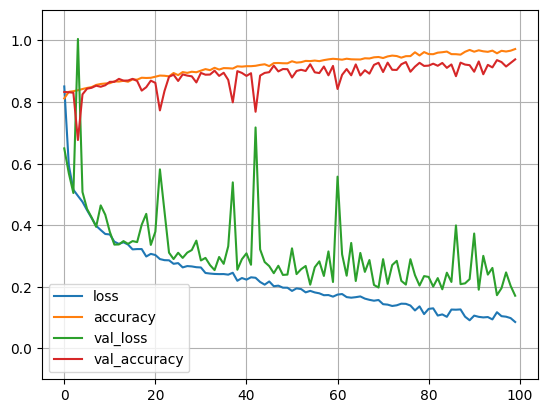

In [230]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [232]:
cnn.load_weights('cnn_respiratory.hdf5') # application des poids enregistrés après l'entrainement au réseau U-net

cnn.compile( loss='sparse_categorical_crossentropy', metrics=('accuracy'))

cnn.evaluate({"mfcc":mfcc_valid,"croma":croma_valid,"mspec":mspec_valid},y_vali)

2023-10-04 14:45:11.511722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - 11s 88ms/step - loss: 0.1713 - accuracy: 0.9386


[0.17130912840366364, 0.9386473298072815]

Exemple de prédiction de pathologie avec le fichier audio d'un patient atteint bronchiestasie

In [251]:
# Exemple de prédiction de pathologie avec le model

file = 'audio_preprocessing/'+x_valid.iloc[204]+'.wav'

print(x_valid.iloc[204])

sound,frequency=lb.load(file)
mfcc_test = lb.feature.mfcc(y=sound,sr=frequency)
croma_test = lb.feature.chroma_stft(y=sound,sr=frequency)
mspec_test = lb.feature.melspectrogram(y=sound,sr=frequency)


111_1b2_Tc_sc_Meditron_1


La représentation des features extraites de l'extrait audio

(20, 259)


[Text(0.5, 1.0, 'Mel spectrogram')]

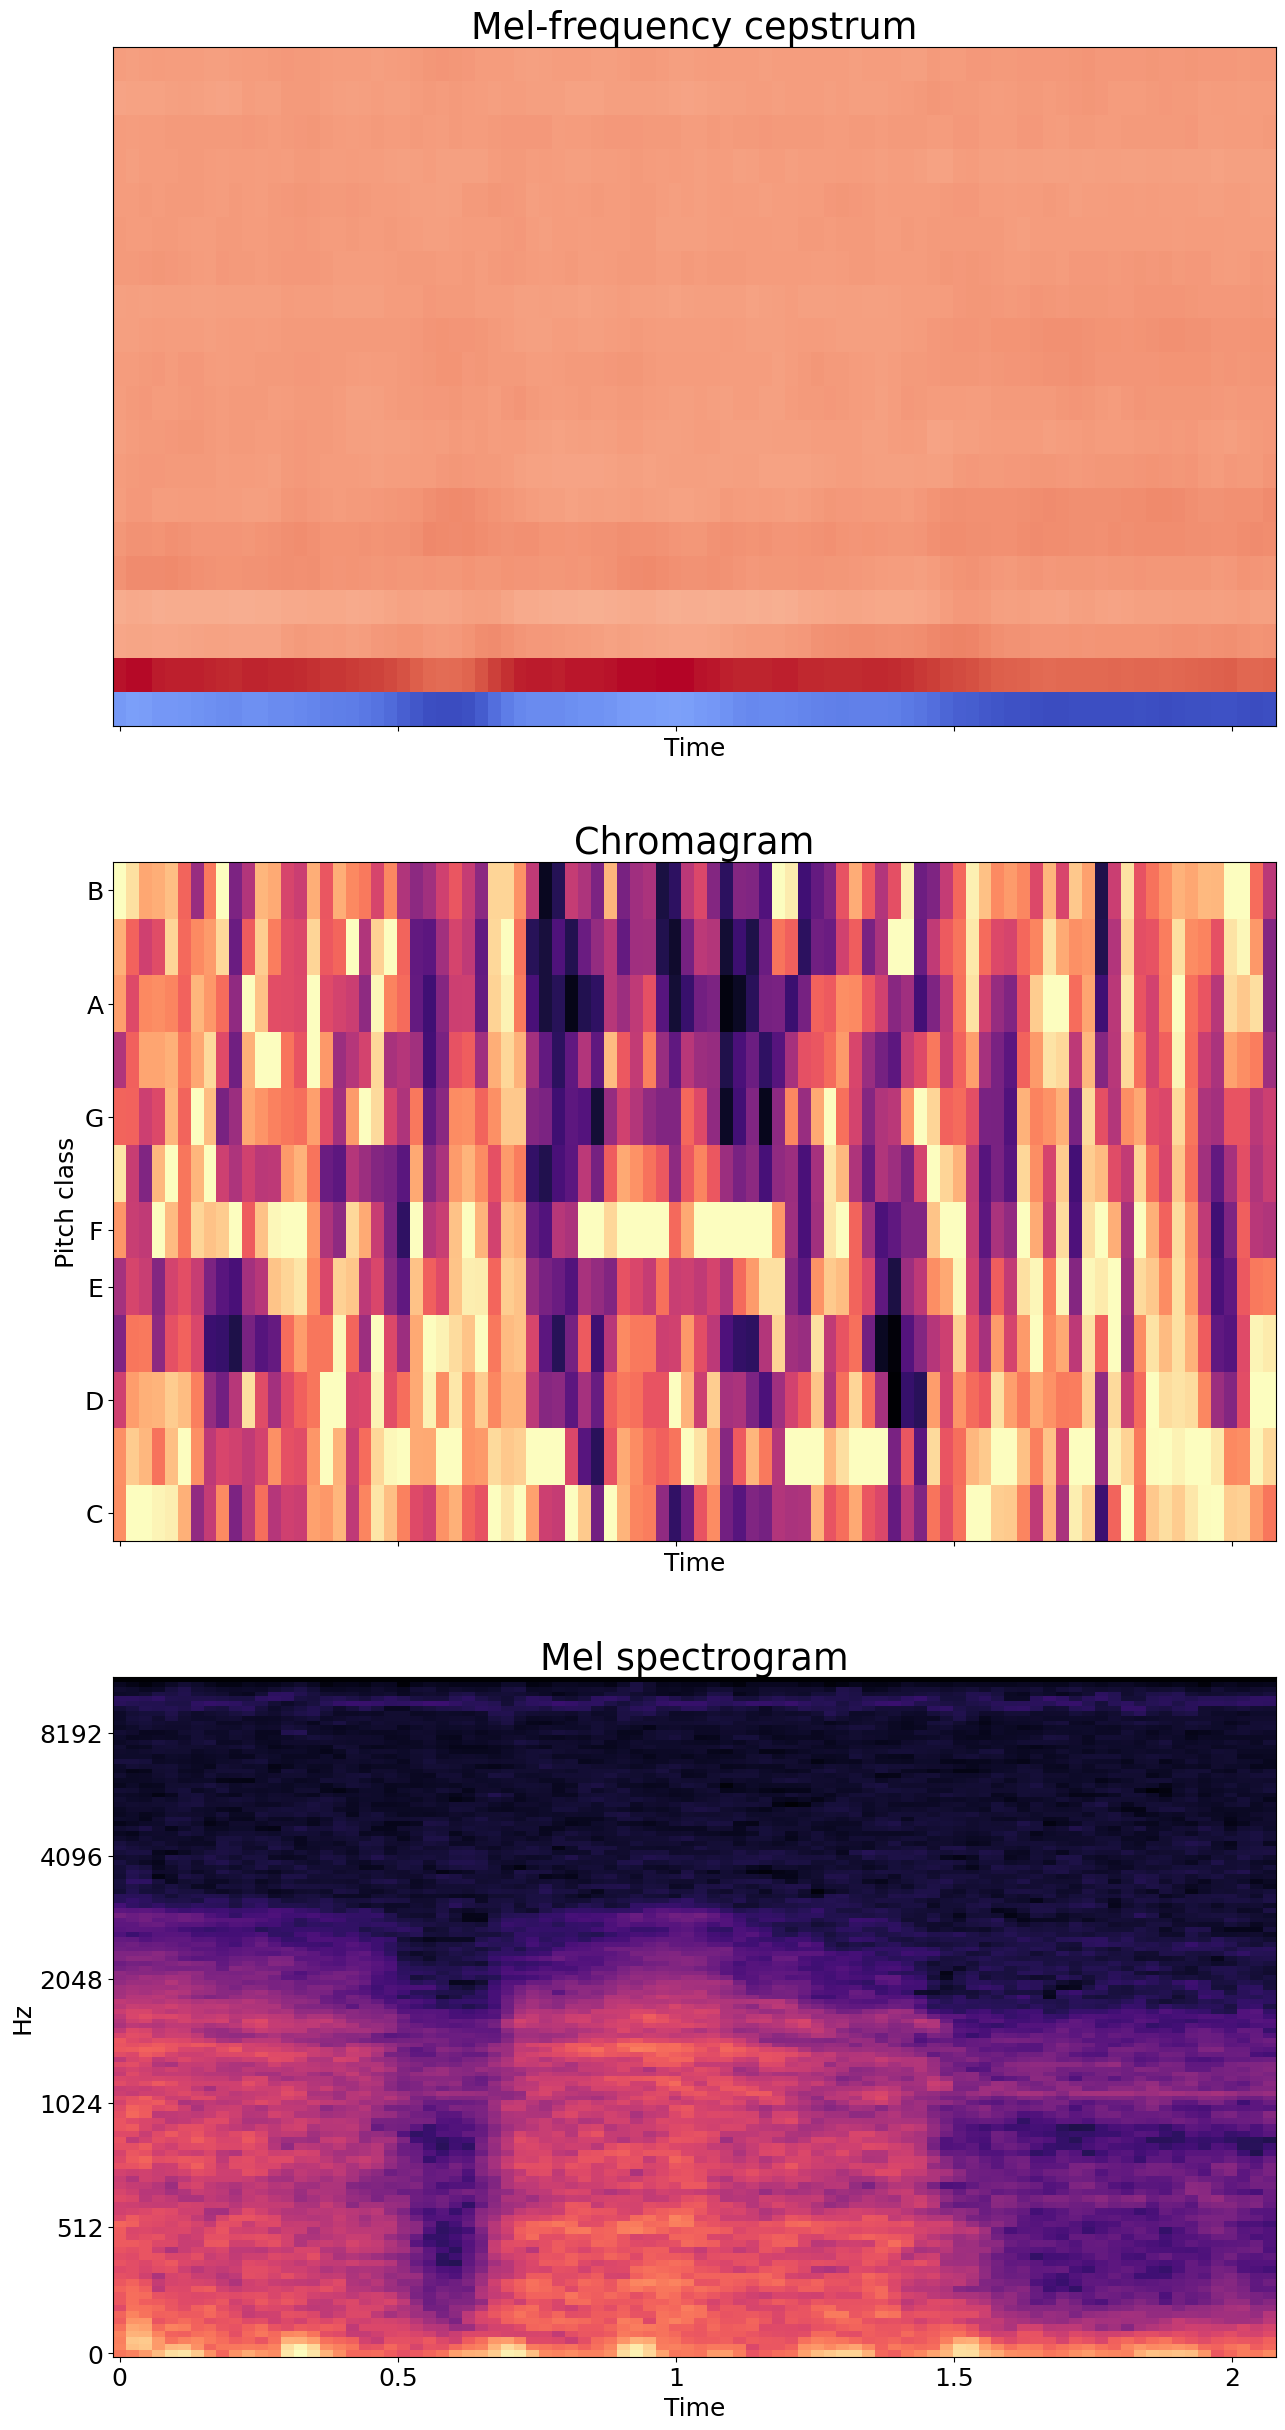

In [286]:


fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
fig.set_figheight(30)
fig.set_figwidth(15)
M_db = lb.power_to_db(mspec_test, ref=np.max)

matplotlib.rcParams.update({'font.size': 22})

print(mfcc_test.shape)
lb.display.specshow(mfcc_test[:,90:180], x_axis='time', ax=ax[0])
ax[0].set(title='Mel-frequency cepstrum')

lb.display.specshow(croma_test[:,90:180], x_axis='time', ax=ax[1],y_axis='chroma')
ax[1].set(title='Chromagram')
lb.display.specshow(M_db[:,90:180], x_axis='time', ax=ax[2],y_axis='mel')
ax[2].set(title='Mel spectrogram')

In [244]:
mfcc_test = mfcc_test.reshape(1,20,259)
croma_test = croma_test.reshape(1,12,259)
M_db = M_db.reshape(1,128,259)
result = cnn.predict({"mfcc": mfcc_test,"croma":croma_test,"mspec":M_db})

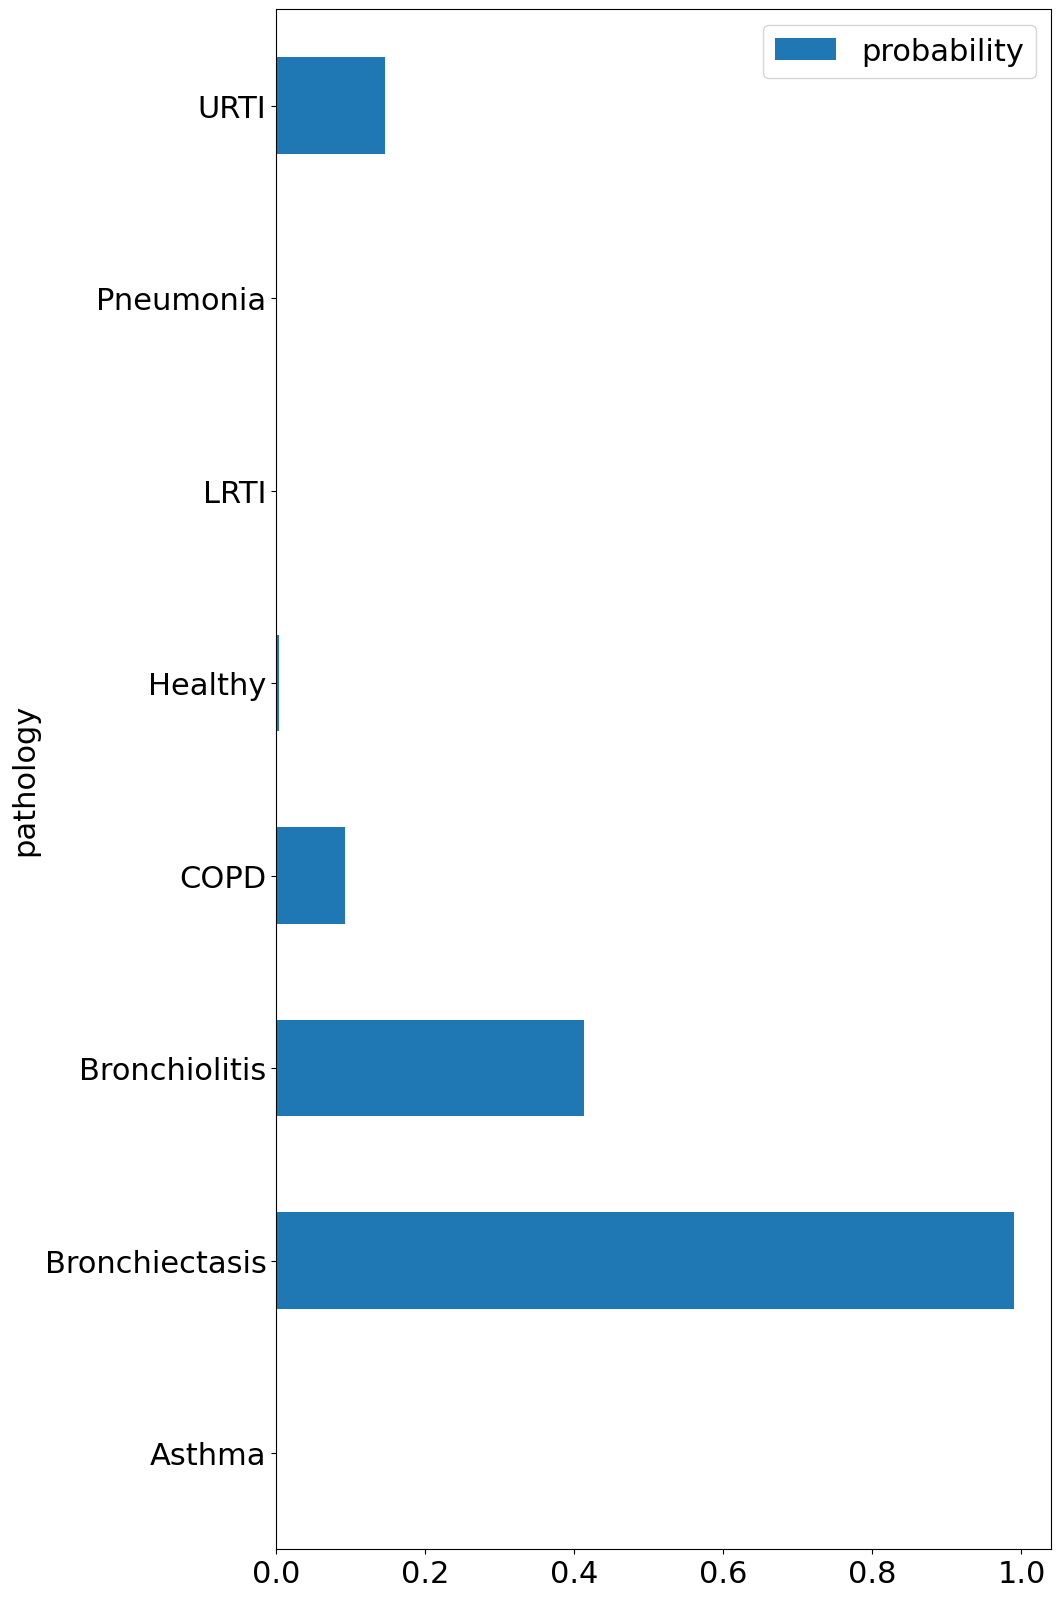

In [290]:

result = result.flatten()
label = le.inverse_transform([0,1,2,3,4,5,6,7])
label = label.squeeze()

dict_of_arrs = { "pathology":label ,"probability": result}
df = pd.DataFrame(dict_of_arrs)
p = df.plot.barh(x='pathology', y='probability',figsize=(10, 20))